# Import Library

In [34]:
import pathlib
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Load Dataset

In [35]:
DATASET_PATH = "dataset"
data_dir = pathlib.Path(DATASET_PATH)

# Data Splitting

In [36]:
train_dataset, val_dataset = tf.keras.utils.audio_dataset_from_directory(
    seed=0,
    batch_size=64,
    output_sequence_length=16000,
    validation_split=0.3,
    directory=data_dir,
    subset="both"
)

Found 6505 files belonging to 4 classes.
Using 4554 files for training.
Using 1951 files for validation.


In [37]:
label_names = train_dataset.class_names
print (label_names)
num_labels = len(label_names)
print (num_labels)

['follow', 'learn', 'tree', 'visual']
4


# Squeezing

In [38]:
def sqeeuze(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

In [39]:
train_dataset = train_dataset.map(sqeeuze, tf.data.AUTOTUNE)
val_dataset = val_dataset.map(sqeeuze, tf.data.AUTOTUNE)

# Get Test Dataset

In [40]:
test_dataset = val_dataset.shard(num_shards=2, index=0)
val_dataset = val_dataset.shard(num_shards=2, index=1)

# Get Spectogram Functions

In [41]:
def get_spectogram(waveform):

    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )

    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]
    return spectogram


In [42]:
def make_ds(ds):
    return ds.map(
        map_func = lambda audio, label : (get_spectogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )

# Converting Audio Array to Spectogram

In [43]:
train_spectogram_ds = make_ds(train_dataset)
val_spectogram_ds = make_ds(val_dataset)
test_spectogram_ds = make_ds(test_dataset)

In [44]:
train_spectogram_ds = train_spectogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectogram_ds = val_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectogram_ds = test_spectogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Build Model

In [45]:
for exmp_spectogram, exmp_spectogram_label in test_spectogram_ds.take(1):
    break

In [46]:
input_shape = exmp_spectogram.shape[1:]
input_shape

TensorShape([124, 129, 1])

In [47]:
norm_layer = layers.Normalization()
norm_layer.adapt(
    data=train_spectogram_ds.map(
        map_func = lambda spec, label : spec
    )
)

In [48]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

In [49]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,375 (1.20 MB)

 Trainable params: 314,372 (1.20 MB)

 Non-trainable params: 3 (16.00 B)

In [50]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Train Model

In [51]:
EPOCHS = 10

history = model.fit(
    train_spectogram_ds,
    validation_data=val_spectogram_ds,
    epochs=EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(
        verbose=1, patience=2
    )
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5362 - loss: 1.0962 - val_accuracy: 0.7781 - val_loss: 0.6195
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7805 - loss: 0.6012 - val_accuracy: 0.8615 - val_loss: 0.4620
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8375 - loss: 0.4615 - val_accuracy: 0.8792 - val_loss: 0.3958
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8887 - loss: 0.3533 - val_accuracy: 0.8875 - val_loss: 0.3666
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8965 - loss: 0.3044 - val_accuracy: 0.9094 - val_loss: 0.3236
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9219 - loss: 0.2410 - val_accuracy: 0.8990 - val_loss: 0.3064
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9104 - loss: 0.2485 - val_accuracy: 0.9062 - val_loss: 0.2954
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9291 - loss: 0.2043 - val_accuracy: 0.9156 - v

# Evaluate Model

In [52]:
test_results = model.evaluate(test_spectogram_ds, return_dict=True)
test_accuracy = test_results["accuracy"]
print (f"Model Accuracy is {test_accuracy*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9443 - loss: 0.1930
Model Accuracy is 93.74%


Text(0, 0.5, 'Accuracy  [%]')

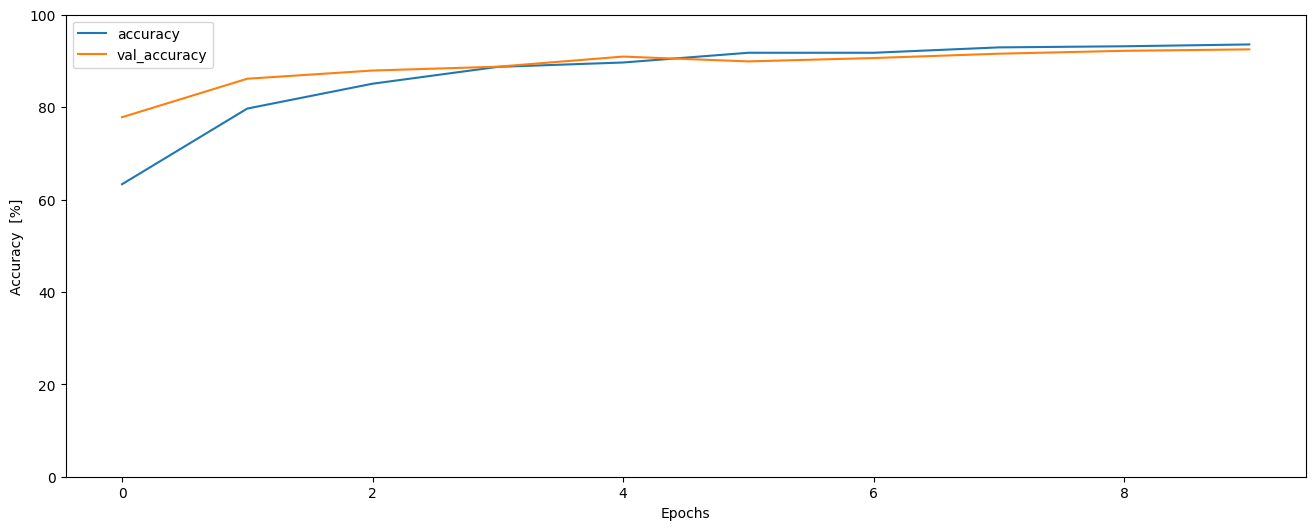

In [53]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.plot(history.epoch, 100*np.array(metrics["accuracy"]), 100*np.array(metrics["val_accuracy"]))
plt.legend(["accuracy", "val_accuracy"])
plt.ylim(0,100)
plt.xlabel("Epochs")
plt.ylabel("Accuracy  [%]")

# Predict

In [54]:
label_names

['follow', 'learn', 'tree', 'visual']

In [55]:
counter = 0
label_names = np.array(label_names)

for i, (spectogram, label) in enumerate (test_spectogram_ds):

    pred = model.predict(spectogram)

    pred_label_idx = tf.argmax(pred, axis=1).numpy()

    orig_label = label_names[label.numpy()]

    pred_label = [label_names[idx] for idx in pred_label_idx]

    for j, label in enumerate (orig_label):
        counter += 1
        print (f"Data {counter}. Original : {label} -> Prediction : {pred_label[j]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Data 1. Original : tree -> Prediction : tree
Data 2. Original : learn -> Prediction : learn
Data 3. Original : tree -> Prediction : tree
Data 4. Original : tree -> Prediction : tree
Data 5. Original : tree -> Prediction : tree
Data 6. Original : visual -> Prediction : visual
Data 7. Original : tree -> Prediction : tree
Data 8. Original : visual -> Prediction : visual
Data 9. Original : learn -> Prediction : learn
Data 10. Original : visual -> Prediction : visual
Data 11. Original : visual -> Prediction : visual
Data 12. Original : follow -> Prediction : follow
Data 13. Original : learn -> Prediction : learn
Data 14. Original : tree -> Prediction : tree
Data 15. Original : tree -> Prediction : tree
Data 16. Original : visual -> Prediction : visual
Data 17. Original : tree -> Prediction : tree
Data 18. Original : tree -> Prediction : tree
Data 19. Original : tree -> Prediction : tree
Data 20. Original : follow -> Prediction : follow
Data 21. Original